In [ ]:
import emission.storage.timeseries.aggregate_timeseries as estag
import emission.storage.timeseries.timequery as estt
import arrow
import emission.core.get_database as edb
from emission.core.wrapper.user import User
import matplotlib.pyplot as plt

In [ ]:
agts = estag.AggregateTimeSeries()
sep_dec_tq_data_ts = estt.TimeQuery("data.ts", arrow.get('2018-03-28', 'YYYY-MM-DD').timestamp, arrow.get('2018-06-06', 'YYYY-MM-DD').timestamp)
client_nav_events_df = agts.get_data_df("stats/client_nav_event", time_query=sep_dec_tq_data_ts)
client_nav_events_df.head()

In [3]:
checked_diary_events = client_nav_events_df[client_nav_events_df.name == "checked_diary"]
print(str(len(checked_diary_events)) + " total events")

607 total events


In [ ]:
information = []
emotion = []
control = []
information_uuids = set()
emotion_uuids = set()
control_uuids = set()
no_clients = set()
for i in range(len(checked_diary_events)):
    uuid = checked_diary_events[i]['user_id']
    try:
        client = edb.get_profile_db().find_one({"user_id": uuid})['client']
        if client == 'urap-2017-information':
            information.append(checked_diary_events[i])
            information_uuids.add(uuid)
        elif client == 'urap-2017-emotion':
            emotion.append(checked_diary_events[i])
            emotion_uuids.add(uuid)
        elif client == 'urap-2017-control':
            control.append(checked_diary_events[i])
            control_uuids.add(uuid)
    except:
        no_clients.add(str(uuid))
for elem in no_clients:
    print(elem + " doesn't have a client for some reason")

In [ ]:
emotion_num_users = len(emotion_uuids)
information_num_users = len(information_uuids)
control_num_users = len(control_uuids)
emotion_total_diary_checks = len(emotion)
information_total_diary_checks = len(information)
control_total_diary_checks = len(control)
print(emotion_num_users, information_num_users, control_num_users)

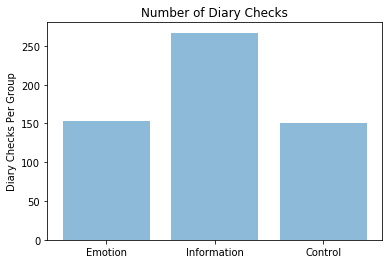

In [6]:
objects = ('Emotion', 'Information', 'Control')
y_pos = range(len(objects))
performance = [emotion_total_diary_checks, information_total_diary_checks, control_total_diary_checks]

# Total number of diary checks per group
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Diary Checks Per Group')
plt.title('Number of Diary Checks')

plt.show()

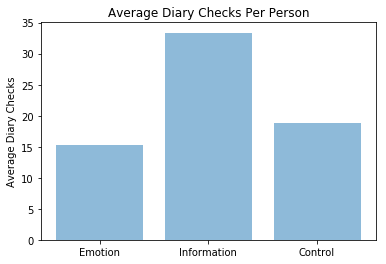

In [7]:
# Average diary checks per person
performance = [emotion_total_diary_checks/emotion_num_users, information_total_diary_checks/information_num_users, control_total_diary_checks/control_num_users]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Diary Checks')
plt.title('Average Diary Checks Per Person')
 
plt.show()

# Permutation Tests

In [8]:
users = edb.get_uuid_db().find()

In [9]:
import pandas as pd
from scipy import stats
import emission.storage.timeseries.abstract_timeseries as esta
from datetime import timedelta, date, tzinfo, datetime
import numpy as np

# Create a dataframe with columns user_id, number of diary checks, week number, and group.
df = pd.DataFrame()
information_count = 0
emotion_count = 0
control_count = 0
for i in range(len(users)):
    user_id = users[i]
    start = arrow.get('2018-03-28', 'YYYY-MM-DD')
    end = arrow.get('2018-06-06', 'YYYY-MM-DD')
    vals = []
    week_val = -1
    for week in arrow.Arrow.range('week', start, end):
        ts = esta.TimeSeries.get_time_series(user_id)
        begin_ts = week.timestamp
        end_ts = (week + timedelta(weeks=1)).timestamp
        last_period_tq = estt.TimeQuery("data.start_ts", begin_ts, end_ts)
        cs_df = ts.get_data_df("analysis/inferred_section", time_query=last_period_tq)
        total = 0
        if cs_df.shape[0] <= 0:
            continue
        try:
            for event in checked_diary_events:
                if event['user_id'] == user_id:
                    if event['ts'] > begin_ts and event['ts'] <= end_ts:
                        total += 1
        except:
            continue
        vals.append(total)
    #Always use lists only where the number of datapoints is greater than 2 otherwise we get a perfect correlation
    weeks = np.arange(len(vals))
    if len(weeks) > 1:
        group = "none"
        try:
            client = edb.get_profile_db().find_one({"user_id": user_id})['client']
            if client == 'urap-2017-information':
                group = "information"
                information_count += 1
            elif client == 'urap-2017-emotion':
                group = "emotion"
                emotion_count += 1
            elif client == 'urap-2017-control':
                group = "control"
                control_count += 1
        except:
            continue
        df = df.append({'uuid': user_id, 'group': group, 'total': sum(vals)}, ignore_index=True)

In [10]:
df.groupby('group').mean()

,total
group,
control,16.666667
emotion,12.727273
information,33.250000


In [11]:
def mean_diff(vals_0, vals_1):
    return np.mean(vals_0) - np.mean(vals_1)

def perm_test(labels, response_vars, stat_func, n):
    '''Labels: Series with two labels, Response_vars series in same order as labels
    stat_func is a function that takes in two series and returns a statistic, n is permutation numnber'''
    unique_label_counts = labels.value_counts()
    label_0 = unique_label_counts.index[0]
    label_1 = unique_label_counts.index[1]
    label_0_count = unique_label_counts[0]
    label_1_count = unique_label_counts[1]
    vals_0 = response_vars[labels == label_0]
    vals_1 = response_vars[labels == label_1]
    observed_stat = stat_func(vals_0, vals_1)
    sample_stats = np.array([])
    ind = labels
    for i in range(n):
        sampler = np.random.permutation(label_0_count + label_1_count)
        new_vals = response_vars.take(sampler).values
        df = pd.DataFrame({'vals': new_vals}, index=ind)
        vals_0 = df[df.index == label_0]['vals']
        vals_1 = df[df.index == label_1]['vals']
        stat = stat_func(vals_0, vals_1)
        sample_stats = np.append(sample_stats, stat)
    perm_mean = np.mean(sample_stats)
    plt.hist(sample_stats)
    plt.show()
    if observed_stat > perm_mean:
        p = np.sum(sample_stats > observed_stat) / len(sample_stats)
    else:
        p = np.sum(sample_stats < observed_stat) / len(sample_stats)
    error = np.sqrt(p*(1-p)/n) * 2 * 100
    print("p val: " + str(p), "error percent = " + str(error))

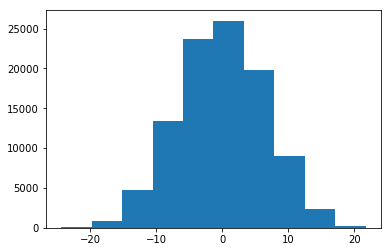

p val: 0.27286 error percent = 0.281714337867


In [12]:
e_c = df[df['group'] != 'information']
perm_test(e_c['group'], e_c['total'], mean_diff, 100000)

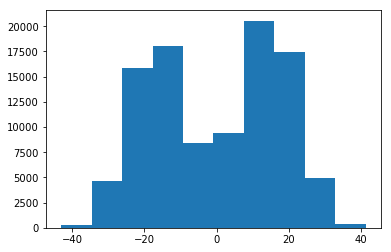

p val: 0.22994 error percent = 0.266133497629


In [13]:
i_c = df[df['group'] != 'emotion']
perm_test(i_c['group'], i_c['total'], mean_diff, 100000)

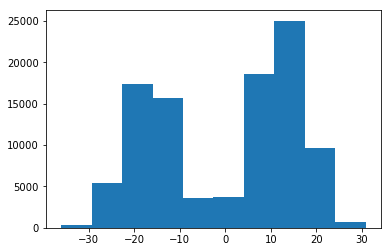

p val: 0.10143 error percent = 0.190936591674


In [14]:
i_e = df[df['group'] != 'control']
perm_test(i_e['group'], i_e['total'], mean_diff, 100000)